In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from metrics import *

In [10]:
data = pd.read_csv('TestData/SimulatedDataCoherence/HighCoherence.csv',header=None)
data = ((data) * 2.0)-1

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


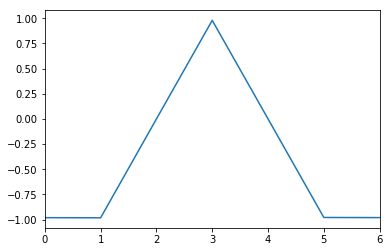

In [11]:
sns.tsplot(np.array(data))

In [233]:
class Rapooc_test(object):
    def __init__(self, D, k, l, K):
        self._D = np.array(D)
        assert k>0 and l >0, "invalid values, k>0 and l>0"
        self._k = k
        self._l = l
        assert K <= k*l and k>=1, "invalid values, 1<= K <= k*l"
        self._K = K
        self._rho = np.ones(D.shape[0])
        self._gamma = np.ones(D.shape[1])
        self._M, self._N = self._D.shape
        self._rows_h_score = None
        self._cols_h_score = None
        self._cluster_H_values = np.array([ [0.0] * (int(self._l) + 1)  
                                    for _ in range(int(self._k + 1))])
    
    @property
    def rho(self):
        return self._rho
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def bicluster_h_values(self):
        assert not self._cluster_H_values is None, "H values have not yet been calculated"
        return self._cluster_H_values

    def initialize(self):
        i = 1
        j = 1
        while (i < self._k or j < self._l):
            if i < self._k:
                i += 1
                alpha = self._argmin_H_(self._rho, self._gamma,'row')
                self._bisect_partitions_(self._D[np.where(self._rho ==alpha)], self._rho, alpha, i,'row')
            if j < self._l:
                j += 1
                print(self._gamma)
                least_coherent_column, lowest_cluster  = self._argmin_H_(self._rho,self._gamma, 'column',j)
                # self._bisect_partitions_(self._D.T, self._gamma, beta, j,'column')   
                self._bisect_columns_(lowest_cluster, least_coherent_column, j)

    def _argmin_H_(self, row_co_cluster, col_co_cluster,option='row',n_col_iterations = 1):
        if (option=='row'):
            data = self._D
            h_min = math.inf
            min_cocluster = 1
            map_array = np.int64(row_co_cluster if option == 'row' else col_co_cluster)
            max_index_in_map = np.max(map_array)
            for i in range(1,max_index_in_map + 1):
                if (list(map_array).count(i) < 2):
                    pass
                else:
                    coherence = PairBasedCoherence(
                        data[np.where((row_co_cluster if option == 'row' else col_co_cluster) == i)]).HP 
                    if (coherence <= h_min):
                        h_min = coherence
                        min_cocluster = i
            return min_cocluster
        else:
            data = self._D.T
            least_coherent_item = -1
            lowest_coherence = 1 # max coherence
            lowest_cluster= 0
            i = 1
            for i in range(1,n_col_iterations):
                #Iter for each cluster
                clusterer = BisectingClusterer(data[np.where(self._gamma == i)])
                aux_least_coherent_item, aux_lowest_coherence = clusterer.least_coherent_item()
                print("% debug % aux " + str(aux_least_coherent_item))
                if(aux_lowest_coherence <= lowest_coherence):
                    lowest_coherence, least_coherent_item = aux_lowest_coherence, aux_least_coherent_item
                    lowest_cluster = i
            print("% debug % item " + str(least_coherent_item) + " cluster "+ str(lowest_cluster))
            return least_coherent_item, lowest_cluster
    
    def _bisect_partitions_ (self, data, mapping_array, cluster_to_replace, new_cluster_index,option='row'):
        clusterer = BisectingClusterer(data)
        bisected_map = clusterer.fit()
        bisected_map_index = 0
        for i in range(0,len(mapping_array)):
            if ((self._rho if option == 'row' else self._gamma)[i] == cluster_to_replace):
                if (bisected_map[bisected_map_index] == 1.0):
                    (self._rho if option == 'row' else self._gamma)[i] = new_cluster_index
                bisected_map_index += 1
                
    def _bisect_columns_(self, cluster_to_replace, least_coherent_column, next_cluster):
        last_occurrence = (np.where(self._gamma == cluster_to_replace)[0][-1] + 1)
        print(last_occurrence)
        self._gamma[least_coherent_column:last_occurrence] = next_cluster

In [234]:
rapooc = Rapooc_test(data,2,3,3)

In [235]:
rapooc.initialize()

[ 1.  1.  1.  1.  1.  1.  1.]
[[ -9.68958000e-01  -9.84715400e-01  -9.81372200e-01  -9.93514600e-01
   -9.78198000e-01  -9.98052920e-01  -9.73312000e-01  -9.63082000e-01
   -9.74058000e-01  -9.95520400e-01  -9.93977200e-01  -9.88521800e-01
   -9.63684000e-01  -9.68342000e-01  -9.77476000e-01  -9.77932000e-01
   -9.78350000e-01  -9.63172000e-01  -9.74208000e-01  -9.87364200e-01
   -9.98620300e-01  -9.61906000e-01  -9.81838400e-01  -9.76854000e-01
   -9.71770000e-01  -9.99581640e-01  -9.67470000e-01  -9.75428000e-01
   -9.60934000e-01  -9.97860400e-01  -9.87398600e-01  -9.61396000e-01
   -9.69480000e-01  -9.71764000e-01  -9.71166000e-01  -9.95829400e-01
   -9.65702000e-01  -9.66004000e-01  -9.97635000e-01  -9.69626000e-01
   -9.96083800e-01  -9.69788000e-01  -9.69406000e-01  -9.98736720e-01
   -9.84215200e-01  -9.92356400e-01  -9.76634000e-01  -9.74300000e-01
   -9.80402400e-01  -9.90020600e-01  -9.90992000e-01  -9.90270000e-01
   -9.83312800e-01  -9.88318600e-01  -9.96946400e-01  -9.922

TypeError: 'int' object is not iterable

In [207]:
rapooc.gamma

array([ 3.,  3.,  3.,  3.,  3.,  2.,  1.])

In [232]:
class BisectingClusterer(object):
    def __init__(self, data):
        
        if data is not None:
            self._data = np.array(data)
            self._I, self._J = self._data.shape
        else:
            print("Empty data")
    
    @property
    def centroids(self):
        if self._centroids is not None:
            return self._centroids
        else:
            print ("centroids not computed yet")
            return [0,0]
    
    def least_coherent_item(self):        
        #this correlation refers the maximum least correlated pair of columns
        print(self._data)
        max_correlation = 1
        least_coherent = 0
        if self._I == 2:
            return -1

        i = 0
        for i in range(self._I - 1):
            correlation = PositiveNegativeCorrelation(self._data[i],
                                                      self._data[i+1],
                                                      self._J).H_pos
            if(correlation < max_correlation):
                max_correlation = correlation
                least_coherent = i
        # returns index of least coherent intem and its correlation
        return least_coherent, max_correlation

    def fit(self):
        self._centroids = self._compute_centroids_()
        bisecting_indices = self._bisect_clusters_(self._centroids)
        return bisecting_indices
    
    def _compute_centroids_(self):
        max_correlation = 0
        centroids = [0,0]
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def _bisect_clusters_(self, centroids):
        cluster_indices = np.zeros(self._I)
        for i in range(self._I):
            correlation0 = PositiveNegativeCorrelation(
                self._data[centroids[0]], self._data[i],self._J).H_pos
            correlation1 = PositiveNegativeCorrelation(
                self._data[centroids[1]], self._data[i],self._J).H_pos
            if(correlation0 <= correlation1):
                cluster_indices[i] = 1
        return cluster_indices

In [152]:
class PositiveNegativeCorrelation(object):
    def __init__(self, x, y, J):
        self._x = x
        self._y = y
        self._J = J
        self._x_mean = np.mean(x)
        self._y_mean = np.mean(y)
        self._H_pos = None
        self._H_neg = None

    @property
    def H_pos(self):
        if self._H_pos is None:
            # print("Computing H positive...")
            self._H_pos = self._compute_H_pos()
            # print("H positive value: " + str(self._H_pos))
        return self._H_pos

    @property
    def H_neg(self):
        if self._H_neg is None:
            # print("Computing H negative...")
            self._H_neg = self._compute_H_neg()
            # print("H negative value: " + str(self._H_neg))
        return self._H_neg

    def _compute_H_pos(self):
        H_pos = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) -
                    (self._y[j] - self._y_mean))/2.0)**2
            H_pos += aux
        H_pos *= 1.0/math.fabs(self._J)
        H_pos = 1 - H_pos
        return H_pos

    def _compute_H_neg(self):
        H_neg = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) +
                    (self._y[j] - self._y_mean))/2.0)**2
            H_neg += aux
        H_neg *= 1.0/math.fabs(self._J)
        H_neg = 1 - H_neg
        return H_neg
    
class PairBasedCoherence(object):
    def __init__(self, X):
        self._X = np.array(X)
        self._I, self._J = X.shape
        self._HP = None

    @property
    def HP(self):
        if self._HP is None:
            # print("Calculating Pair based coherence..")
            self._HP = self._compute_HP_()
            # print("Paired based coherence value: " + str(self._HP))
        return self._HP

    def _compute_HP_(self):
        HP = 0
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i==j): 
                    break
                x = self._X[i]
                y = self._X[j]
                correlation = PositiveNegativeCorrelation(x, y,self._J)
                H0 = correlation.H_pos
                # H0 = max(correlation.H_pos,correlation.H_neg)
                HP += H0
        HP *= math.fabs(2.0)/(math.fabs(self._I)*(math.fabs(self._I)-1)) # if self._I > 1 else 0
        
        return HP

In [114]:
y = np.array([1,2,3,3,3,3,4,5,])
np.where(y==3)

(array([2, 3, 4, 5]),)

In [109]:
x = y[np.where(y==3)]
x

array([3, 3, 3, 3])

In [110]:
for i in np.where(y==3)[0].tolist()[3:]:
    print(i)

5


In [111]:
np.nditer(np.where(y==3))

In [112]:
y[3:] = -1

In [115]:
y

array([1, 2, 3, 3, 3, 3, 4, 5])

In [119]:
 np.where(y==3)[0][-1]

5

In [220]:
y

array([1, 2, 3, 3, 3, 3, 4, 5])

In [222]:
y[2:7]

array([3, 3, 3, 3, 4])